# Current Plan
1. Create a function to calculate the distance between descriptions, use that function to naively classify new descriptions. probably looks something like a search function.
2. Grab a text classification model of hugging face and fine-tune it on the dataset.

In [ ]:
# setup requirements, which aren't loading in the venv for some reason
%pip install -r requirements.txt

## Data Preperation

### Cleaning 

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

with open('data/Datas.csv') as file:
    data = pd.read_csv(file)

### Augmentation/Expansion

### Sampling and splitting

In [ ]:

# Split data into training and testing sets in a stratified way, despite the minimum class only having 2 samples 
cat_count = data.value_counts('Category')
subcat_count = data.value_counts(['Category', 'Sub_Category'])

# handle the case where the minimum class has only 2 samples
data = data.groupby('Category').filter(lambda x: len(x) > 2) # this method works, but my pandas is pretty rusty. 

train, test = train_test_split(data, test_size=0.2, stratify=data['Category'], random_state=42) # random_state for reproducibility
train, val = train_test_split(train, test_size=0.3, stratify=train['Category'], random_state=77) 

### Tokenization

In [67]:
# Function to measure distance 
from sklearn.feature_extraction.text import TfidfVectorizer
# have a think about whether the data needs cleaning


tfidf = TfidfVectorizer() # use token_pattern to remove punctuation if needed
tfidf.fit(train['Description']) # val set not included here 
tfidf_array = tfidf.transform(train['Description']).toarray()

data_vectorized = pd.DataFrame(tfidf_array, 
                     columns=tfidf.get_feature_names_out(),
                     index=train['Description'])

## 1. Basic SciKitLearn Models

### Investigating cosine similarity

In [37]:
# cosine distance
from sklearn.metrics.pairwise import cosine_similarity

values = cosine_similarity(data_vectorized, data_vectorized) # dist() = x.y / (||x|| * ||y||) or sum(x * y) / (sqrt(sum(x^2)) * sqrt(sum(y^2)))
similarities = pd.DataFrame(values, index=train.index, columns=train.index)

# plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarities)

In [116]:
from sklearn.metrics import  confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def evaluate(Y_true, Y_pred, dataset_name="Train"):
    # function to evaluate the model
    #confusion_matrix = confusion_matrix(val['Category'], val_hat)
    #FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    #FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    #TP = np.diag(confusion_matrix)
    #TN = confusion_matrix.sum() - (FP + FN + TP)
    
    # evaluate using the sklearn functions
    accuracy = np.mean(accuracy_score(Y_true, Y_pred)) #(TP + TN) / (TP + FP + FN + TN)
    recall = recall_score(Y_true, Y_pred, average='weighted') #TP / (TP + FN)
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    
    # because of our sparse data, precision is ill defined for many of our classes
    
    # plot
    print(dataset_name," Accuracy:", accuracy)
    print(dataset_name," F1 Score", f1)
    
def plot_confusion(Y_true, Y_pred, model, fig_name="confusion.png"):
    confusion = confusion_matrix(Y_true, Y_pred)
    disp = ConfusionMatrixDisplay(confusion, display_labels= model.classes_)
    disp.plot(xticks_rotation=90)
    plt.savefig('analysis/'+fig_name, bbox_inches='tight')
    plt.show()

### SKLearn Models
Testing the variety of models, SVM and Naive Bayes worked the best on the raw data, while KNN and RF didn't work as well as expected.
All models suffered from the distibution issue in the datset, only predicting the most common classes (food and entertainment).

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(data_vectorized.values, train['Category'])

# predict
val_hat = knn.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train['Category'], knn.predict(tfidf.transform(train['Description']).toarray()), "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn.png")

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# setup RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data_vectorized.values, train['Category'])

# predict
train_hat = rf.predict(tfidf.transform(train['Description']).toarray())
val_hat = rf.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, rf, "confusion_matricies/rf.png")

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# setup NB
nb = MultinomialNB()
nb.fit(data_vectorized.values, train['Category'])

# predict
train_hat = nb.predict(tfidf.transform(train['Description']).toarray())
val_hat = nb.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, nb, "confusion_matricies/nb.png")

In [ ]:
# SVM
from sklearn.svm import SVC

# prepare data labels to be numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Category'])
train_Y = le.transform(train['Category'])
val_Y = le.transform(val['Category'])

# setup SVM
svm = SVC(kernel='linear')
svm.fit(data_vectorized.values, train_Y)

# predict
train_hat = svm.predict(tfidf.transform(train['Description']).toarray())
val_hat = svm.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train_Y, train_hat, "Test")
evaluate(val_Y, val_hat, "Val")
plot_confusion(val_Y, val_hat, svm, "confusion_matricies/svm.png")

## 2. HuggingFace Models

### Embedding

In [ ]:
%pip install -U sentence-transformers

In [134]:
# MiniLM encoding; full guide: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
import pandas as pd 
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(train['Description'].values)

assert len(embeddings) == train['Description'].count() 

Test  Accuracy: 0.7908745247148289
Test  F1 Score 0.7237749318325486
Val  Accuracy: 0.7543859649122807
Val  F1 Score 0.6755142083249586


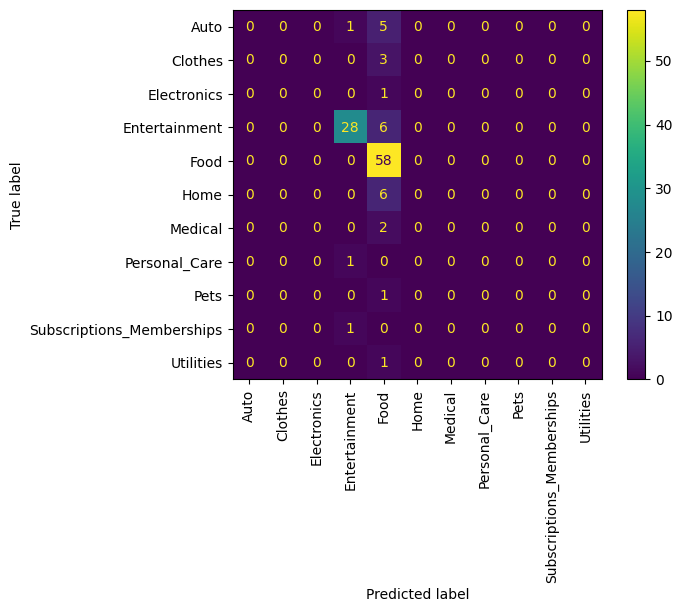

In [138]:
# KNN on embeddings
from sklearn.neighbors import KNeighborsClassifier

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(embeddings, train['Category']) # should still have the same indicies

# predict
train_hat = knn.predict(model.encode(train['Description'].values))
val_hat = knn.predict(model.encode(val['Description'].values))

evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn_embeddings.png")